In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random 

import statsmodels.formula.api as sm
from statsmodels.graphics.gofplots import ProbPlot
import math
from sklearn import linear_model

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

import datetime
import sys

### for debugging purposes
###sys.version
### should say:
###'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n
###[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'


### begin ETL

d = pd.read_csv('../data/raw_data.csv')
d_working = d.dropna(how='any')


### create numeric mapping for locations
unique_locs = d.Location.value_counts().index.tolist()
loc_map = [x for x in range(len(unique_locs))]
loc_set = dict(zip(unique_locs, loc_map))
#loc_set

d_working['numeric_location'] = d_working['Location'].map(lambda x: loc_set[x] if x in loc_set.keys() else -1)

### get dummies for locations
dum = pd.get_dummies(d_working['numeric_location'])
dum.columns = ['loc_%s' % (x) for x in dum.columns.tolist()]
d_working = pd.concat([d_working, dum], axis = 1)

### create week aggregates

def week_num(date_string):
    date = datetime.datetime.strptime(date_string,'%m/%d/%y')
    return datetime.date.isocalendar(date)[1]

d_working['week_number'] = d_working['Date'].apply(week_num)


### create a calculated field that staggers the google trends to the next day
d_working['stagger_second_flu_trend'] = [0] + d_working['google_second_wave_trend'].tolist()[:-1]
d_working['stagger_drug_resistant'] = [0] + d_working['google_drug_resistant_trend'].tolist()[:-1]




d_working.head()

/Users/melissatufan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Location,Treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,numeric_location,...,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,week_number,stagger_second_flu_trend,stagger_drug_resistant
0,3/10/18,eca- front desk,0.0,1594,0.0,Nikki,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,10,0.0,0.0
1,3/11/18,eca- front desk,0.0,1583,11.0,Nikki,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,10,0.0,0.0
2,3/12/18,eca- front desk,0.0,1573,10.0,Nikki,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,11,0.0,0.0
3,3/13/18,eca- front desk,0.0,1566,7.0,Nikki,0.0,48.0,0.0,1,...,0,0,0,0,0,0,0,11,0.0,0.0
4,3/14/18,eca- front desk,0.0,1549,17.0,Nikki,0.0,0.0,0.0,1,...,0,0,0,0,0,0,0,11,0.0,48.0


In [2]:
## Functions to summarize and plot model plots ##


def ols_model_summarize(formula_str, data, cov_type, cov_kwds):
    model = sm.ols(formula=formula_str, data=data)
    model_fit = model.fit(cov_type='cluster',cov_kwds=cov_kwds, use_t=True)


    # R style linear model plots via https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

    ###############Calculations required for some of the plots################
    # fitted values (need a constant term for intercept)
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
    # normalized residuals
    model_norm_residuals = model_fit.get_influence().resid_studentized_internal
    # absolute squared normalized residuals
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
    # leverage, from statsmodels internals
    model_leverage = model_fit.get_influence().hat_matrix_diag
    # cook's distance, from statsmodels internals
    model_cooks = model_fit.get_influence().cooks_distance[0]



    ###########Residual Plot######################
    plot_lm_1 = plt.figure(1)
    plot_lm_1.set_figheight(4)
    plot_lm_1.set_figwidth(6)
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'amount_used', data=data, 
                              lowess=True, 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));
    
    ######### QQplot#############################
    QQ = ProbPlot(model_norm_residuals)
    plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
    plot_lm_2.set_figheight(4)
    plot_lm_2.set_figwidth(6)
    plot_lm_2.axes[0].set_title('Normal Q-Q')
    plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
    plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
    # annotations
    abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3):
        plot_lm_2.axes[0].annotate(i, 
                                   xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                       model_norm_residuals[i]));
    

    ############ Scale location plot ###############
    plot_lm_3 = plt.figure(3)
    plot_lm_3.set_figheight(4)
    plot_lm_3.set_figwidth(6)
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_3.axes[0].set_title('Scale-Location')
    plot_lm_3.axes[0].set_xlabel('Fitted values')
    plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
    # annotations
    abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
    for i in abs_norm_resid_top_3:
        plot_lm_3.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_norm_residuals_abs_sqrt[i]));
    

    ######### Leverage Plot ##################
    plot_lm_4 = plt.figure(4)
    plot_lm_4.set_figheight(4)
    plot_lm_4.set_figwidth(6)
    plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
    sns.regplot(model_leverage, model_norm_residuals, 
                scatter=False, 
                ci=False, 
                lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_4.axes[0].set_xlim(0, 0.20)
    plot_lm_4.axes[0].set_ylim(-3, 5)
    plot_lm_4.axes[0].set_title('Residuals vs Leverage')
    plot_lm_4.axes[0].set_xlabel('Leverage')
    plot_lm_4.axes[0].set_ylabel('Standardized Residuals')
    # annotations
    leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
    for i in leverage_top_3:
        plot_lm_4.axes[0].annotate(i, 
                                   xy=(model_leverage[i], 
                                       model_norm_residuals[i]))
    
    # shenanigans for cook's distance contours
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')
    p = len(model_fit.params) # number of model parameters
    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50), 
          'Cook\'s distance') # 0.5 line
    graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
          np.linspace(0.001, 0.200, 50)) # 1 line
    plt.legend(loc='upper right');

    return model_fit.summary()


def mixedlm_model_summarize(formula_str, data, groups):
    model = sm.mixedlm(formula=formula_str, data=data, groups=groups)
    model_fit = model.fit()
    
        # R style linear model plots via https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

    ###############Calculations required for some of the plots################
    # fitted values (need a constant term for intercept)
    model_fitted_y = model_fit.fittedvalues
    # model residuals
    model_residuals = model_fit.resid
#     # normalized residuals
#     model_norm_residuals = model_fit.get_influence().resid_studentized_internal
#     # absolute squared normalized residuals
#     model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    # absolute residuals
    model_abs_resid = np.abs(model_residuals)
#     # leverage, from statsmodels internals
#     model_leverage = model_fit.get_influence().hat_matrix_diag
#     # cook's distance, from statsmodels internals
#     model_cooks = model_fit.get_influence().cooks_distance[0]



    ###########Residual Plot######################
    plot_lm_1 = plt.figure(1)
    plot_lm_1.set_figheight(4)
    plot_lm_1.set_figwidth(6)
    plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'amount_used', data=data, 
                              lowess=True, 
                              scatter_kws={'alpha': 0.5}, 
                              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm_1.axes[0].set_title('Residuals vs Fitted')
    plot_lm_1.axes[0].set_xlabel('Fitted values')
    plot_lm_1.axes[0].set_ylabel('Residuals')

    # annotations
    abs_resid = model_abs_resid.sort_values(ascending=False)
    abs_resid_top_3 = abs_resid[:3]
    for i in abs_resid_top_3.index:
        plot_lm_1.axes[0].annotate(i, 
                                   xy=(model_fitted_y[i], 
                                       model_residuals[i]));
    
#     ######### QQplot#############################
#     QQ = ProbPlot(model_norm_residuals)
#     plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
#     plot_lm_2.set_figheight(4)
#     plot_lm_2.set_figwidth(6)
#     plot_lm_2.axes[0].set_title('Normal Q-Q')
#     plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
#     plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
#     # annotations
#     abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
#     abs_norm_resid_top_3 = abs_norm_resid[:3]
#     for r, i in enumerate(abs_norm_resid_top_3):
#         plot_lm_2.axes[0].annotate(i, 
#                                    xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
#                                        model_norm_residuals[i]));
    

#     ############ Scale location plot ###############
#     plot_lm_3 = plt.figure(3)
#     plot_lm_3.set_figheight(4)
#     plot_lm_3.set_figwidth(6)
#     plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
#     sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
#                 scatter=False, 
#                 ci=False, 
#                 lowess=True,
#                 line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
#     plot_lm_3.axes[0].set_title('Scale-Location')
#     plot_lm_3.axes[0].set_xlabel('Fitted values')
#     plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');
#     # annotations
#     abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
#     abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
#     for i in abs_norm_resid_top_3:
#         plot_lm_3.axes[0].annotate(i, 
#                                    xy=(model_fitted_y[i], 
#                                        model_norm_residuals_abs_sqrt[i]));
    

#     ######### Leverage Plot ##################
#     plot_lm_4 = plt.figure(4)
#     plot_lm_4.set_figheight(4)
#     plot_lm_4.set_figwidth(6)
#     plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
#     sns.regplot(model_leverage, model_norm_residuals, 
#                 scatter=False, 
#                 ci=False, 
#                 lowess=True,
#                 line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
#     plot_lm_4.axes[0].set_xlim(0, 0.20)
#     plot_lm_4.axes[0].set_ylim(-3, 5)
#     plot_lm_4.axes[0].set_title('Residuals vs Leverage')
#     plot_lm_4.axes[0].set_xlabel('Leverage')
#     plot_lm_4.axes[0].set_ylabel('Standardized Residuals')
#     # annotations
#     leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
#     for i in leverage_top_3:
#         plot_lm_4.axes[0].annotate(i, 
#                                    xy=(model_leverage[i], 
#                                        model_norm_residuals[i]))
    
#     # shenanigans for cook's distance contours
#     def graph(formula, x_range, label=None):
#         x = x_range
#         y = formula(x)
#         plt.plot(x, y, label=label, lw=1, ls='--', color='red')
#     p = len(model_fit.params) # number of model parameters
#     graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
#           np.linspace(0.001, 0.200, 50), 
#           'Cook\'s distance') # 0.5 line
#     graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
#           np.linspace(0.001, 0.200, 50)) # 1 line
#     plt.legend(loc='upper right');


    return model_fit.summary()






**Modeling data with outliers and sabotage**

/Users/melissatufan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.423
Date:                Mon, 16 Apr 2018   Prob (F-statistic):              0.180
Time:                        15:04:37   Log-Likelihood:                -1009.3
No. Observations:                 212   AIC:                             2023.
Df Residuals:                     210   BIC:                             2029.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6296      1.923      3.968      0.011       2.686      12.573
Treatment      4.4223      2.841      1.557      0.180      -2.881      11.725
==============================================================================
Omnibus:                      264.110   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23723.717
Skew:                           4.987   Prob(JB):                         0.00
Kurtosis:                      53.855   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

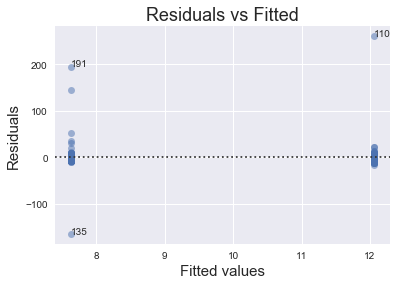

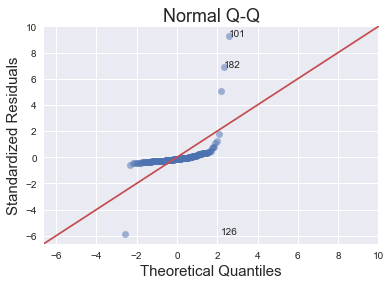

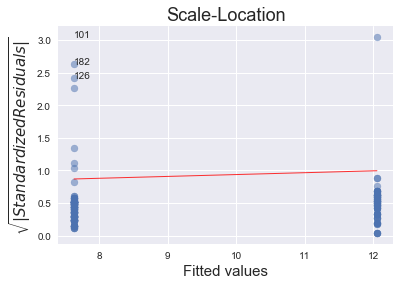

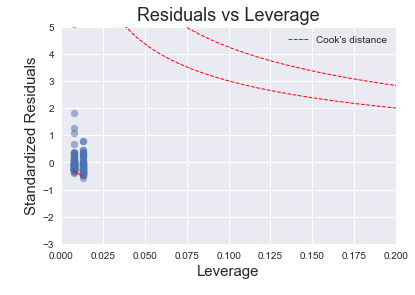

In [3]:
#Model clustered on location and week number###

lm_simple = 'amount_used ~ Treatment'
cov_keys_weeksloc={'groups': [d_working['numeric_location'],d_working['week_number']]}


ols_model_summarize(formula_str=lm_simple, data=d_working, cov_type='cluster', cov_kwds=cov_keys_weeksloc)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                -1.141e+16
Date:                Mon, 16 Apr 2018   Prob (F-statistic):               1.00
Time:                        15:04:38   Log-Likelihood:                -1003.0
No. Observations:                 212   AIC:                             2030.
Df Residuals:                     200   BIC:                             2070.
Df Model:                          11                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6240      1.227      6.214      0.002       4.470      10.778
Treatment      3.2129      1.663      1.932      0.111      -1.061       7.487
loc_0         -7.5029      1.204     -6.234      0.002     -10.597      -4.409
loc_1          1.8691      1.784      1.048      0.343      -2.716       6.454
loc_2         -0.8773      2.421     -0.362      0.732      -7.102       5.347
loc_3         -2.2773      1.410     -1.615      0.167      -5.902       1.348
loc_4         -7.5805      2.206     -3.437      0.018     -13.250      -1.911
loc_5          5.1195      3.215      1.593      0.172      -3.144      13.383
loc_6         11.2727      7.508      1.501      0.194      -8.026      30.572
loc_7          1.5797     16.766      0.094      0.929     -41.520      44.679
loc_8         13.9703     10.087      1.385      0.225     -11.958      39.899
loc_9         -6.5222      1.531     -4.261      0.008     -10.457      -2.587
loc_10        -1.4273      2.553     -0.559      0.600      -7.991       5.137
==============================================================================
Omnibus:                      264.056   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26516.176
Skew:                           4.929   Prob(JB):                         0.00
Kurtosis:                      56.895   Cond. No.                     9.74e+15
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The smallest eigenvalue is 2.82e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

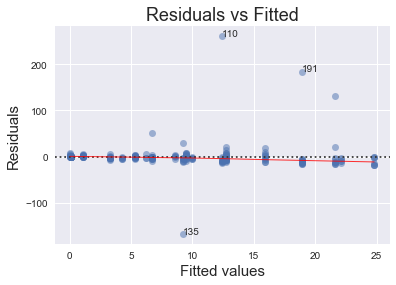

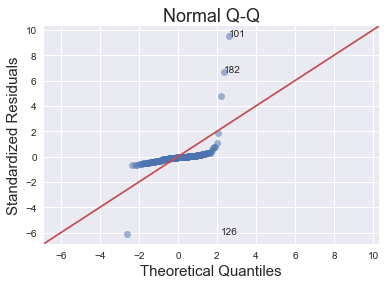

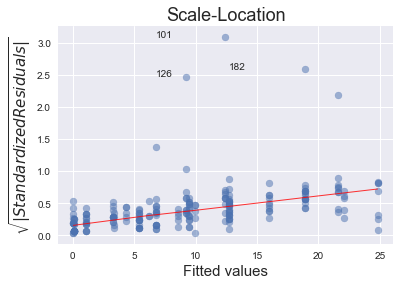

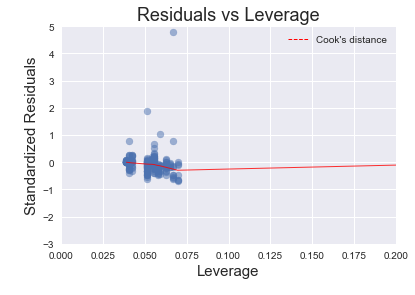

In [4]:
#Model with dummy location variables, clustered on week number###


lm_locs = 'amount_used ~ Treatment + \
                 loc_0 + loc_1 + loc_2 + loc_3 + loc_4 + \
                 loc_5 + loc_6 + loc_7 + loc_8 + loc_9 + \
                 loc_10'
cov_keys_weeks={'groups': [d_working['week_number']]}


ols_model_summarize(formula_str=lm_locs, data=d_working, cov_type='cluster', cov_kwds=cov_keys_weeks)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: amount_used
No. Observations: 212     Method:             REML       
No. Groups:       11      Scale:              796.8782   
Min. group size:  4       Likelihood:         -1005.2287 
Max. group size:  28      Converged:          Yes        
Mean group size:  19.3                                   
----------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    7.809     2.668  2.927  0.003   2.579  13.039
Treatment    4.146     4.101  1.011  0.312  -3.891  12.183
groups RE   11.047     0.864                              
=========================================================

"""

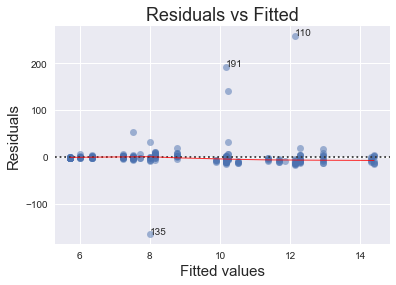

In [5]:
#Mixed effects model, random intercepts

mm_loc_group = d_working['numeric_location']

mixedlm_model_summarize(formula_str=lm_simple, data=d_working, groups=mm_loc_group)


**Modeling data minus outliers and sabotage**

In [6]:
d_working_2 = d_working[d_working['is_suspicious'] == 0]

/Users/melissatufan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/melissatufan/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     6.256
Date:                Mon, 16 Apr 2018   Prob (F-statistic):             0.0544
Time:                        15:04:39   Log-Likelihood:                -701.03
No. Observations:                 200   AIC:                             1406.
Df Residuals:                     198   BIC:                             1413.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5039      1.519      4.280      0.008       2.598      10.410
Treatment      2.8342      1.133      2.501      0.054      -0.079       5.747
==============================================================================
Omnibus:                      139.708   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1244.058
Skew:                           2.643   Prob(JB):                    7.18e-271
Kurtosis:                      14.016   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

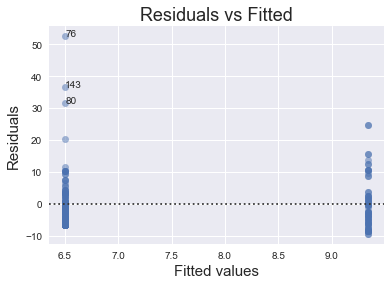

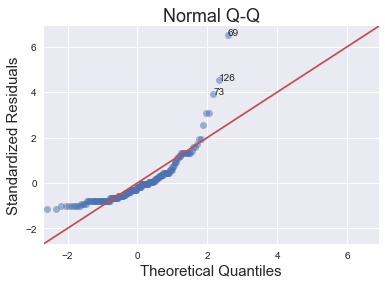

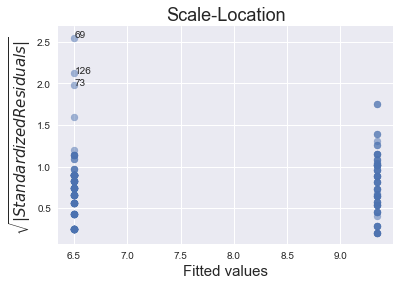

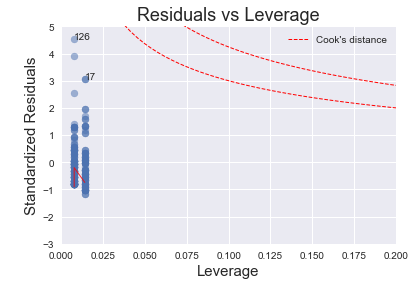

In [7]:
#Model clustered on location and week number###
#lm_simple = 'amount_used ~ Treatment'
cov_keys_weeksloc={'groups': [d_working_2['numeric_location'],d_working_2['week_number']]}


ols_model_summarize(formula_str=lm_simple, data=d_working_2, cov_type='cluster', cov_kwds=cov_keys_weeksloc)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                 3.017e+16
Date:                Mon, 16 Apr 2018   Prob (F-statistic):           2.49e-41
Time:                        15:04:40   Log-Likelihood:                -663.55
No. Observations:                 200   AIC:                             1351.
Df Residuals:                     188   BIC:                             1391.
Df Model:                          11                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.5651      0.783      8.389      0.000       4.553       8.577
Treatment      1.0465      0.892      1.173      0.294      -1.248       3.341
loc_0         -6.1107      0.772     -7.920      0.001      -8.094      -4.127
loc_1          4.0886      0.721      5.673      0.002       2.236       5.941
loc_2          1.2122      1.990      0.609      0.569      -3.905       6.329
loc_3         -0.6767      1.208     -0.560      0.599      -3.781       2.428
loc_4         -4.7634      0.196    -24.346      0.000      -5.266      -4.260
loc_5          7.2617      1.904      3.815      0.012       2.368      12.155
loc_6          3.2122      1.585      2.027      0.099      -0.862       7.286
loc_7         -0.7232      1.599     -0.452      0.670      -4.833       3.387
loc_8          7.3466      1.335      5.503      0.003       3.915      10.778
loc_9         -4.4556      1.124     -3.965      0.011      -7.345      -1.567
loc_10         0.1733      1.533      0.113      0.914      -3.768       4.115
==============================================================================
Omnibus:                      183.954   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3828.773
Skew:                           3.466   Prob(JB):                         0.00
Kurtosis:                      23.283   Cond. No.                     8.62e+15
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The smallest eigenvalue is 3.38e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

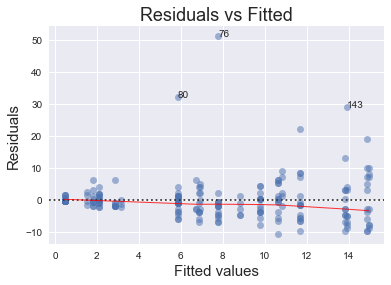

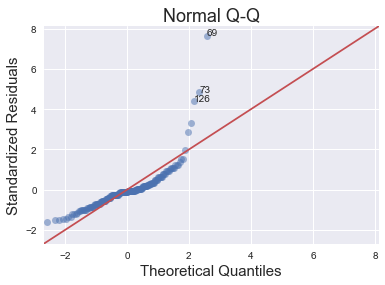

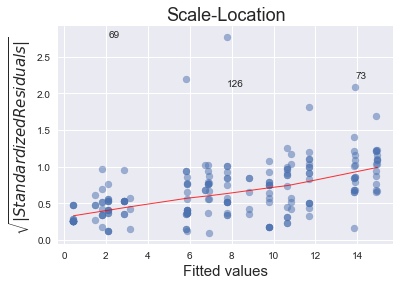

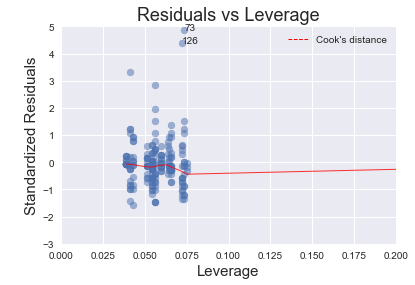

In [8]:
#Model with dummy location variables, clustered on week number###


# lm_locs = 'amount_used ~ Treatment + \
#                  loc_0 + loc_1 + loc_2 + loc_3 + loc_4 + \
#                  loc_5 + loc_6 + loc_7 + loc_8 + loc_9 + \
#                  loc_10'
cov_keys_weeks={'groups': [d_working_2['week_number']]}


ols_model_summarize(formula_str=lm_locs, data=d_working_2, cov_type='cluster', cov_kwds=cov_keys_weeks)

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: amount_used
No. Observations: 200     Method:             REML       
No. Groups:       11      Scale:              47.3723    
Min. group size:  4       Likelihood:         -677.7040  
Max. group size:  28      Converged:          Yes        
Mean group size:  18.2                                   
----------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    7.100     1.475  4.815  0.000   4.209   9.990
Treatment    1.238     1.067  1.159  0.246  -0.854   3.329
groups RE   19.241     1.457                              
=========================================================

"""

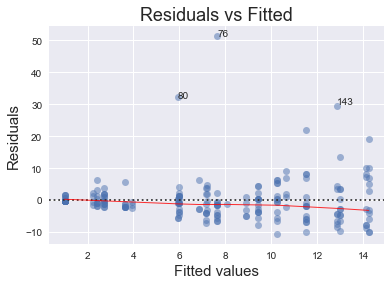

In [9]:
#Mixed effects model, random intercepts

mm_loc_group = d_working_2['numeric_location']

mixedlm_model_summarize(formula_str=lm_simple, data=d_working_2, groups=mm_loc_group)